In [1]:
from pathlib import Path

import fig04to05 as nb
import hcp_utils as hcp
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from matplotlib.colors import ListedColormap
from nilearn import plotting

from fmri_timescales import timescale_utils

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
# !! optional: run this code block to refit LLS and NLS estimators, requires full HCP 7T dataset !! #

# set paths to input HCP dataset (if available), output directory
input_path = Path("/Volumes/griegner/datasets/hcp/rawdata7T")
output_path = Path("/Volumes/griegner/datasets/hcp/timescales7T")

# initialize estimators, var_n_lags that minimizes MSE in HCP simulations
n_timepoints = 3600
lls = timescale_utils.LLS(var_estimator="newey-west", var_n_lags=11, n_jobs=-2)
nls = timescale_utils.NLS(
    var_domain="autocorrelation", var_estimator="newey-west", var_n_lags=15, acf_n_lags=n_timepoints // 10, n_jobs=-2
)

# re-fit estimators if full dataset available
if len(list(input_path.rglob("*.dtseries.nii"))) == 707:
    nb.fit_timescale_models(input_path, output_path, lls, nls)

In [3]:
# !! else: load intermediate subject-level estimates !! #

# timescale estimates, newey-west standard errors, t-statistics, relative standard errors

maps = {"lls": nb.get_maps("lls"), "nls": nb.get_maps("nls")}
print("LLS + NLS column names: ", *maps["lls"].keys(), sep="  ")

LLS + NLS column names:   tau  se(tau)  tstat  rse  tau_N  se(tau_N)  tstat_N  rse_N


cbar = 0-2.7


(-60.0, 27.0)

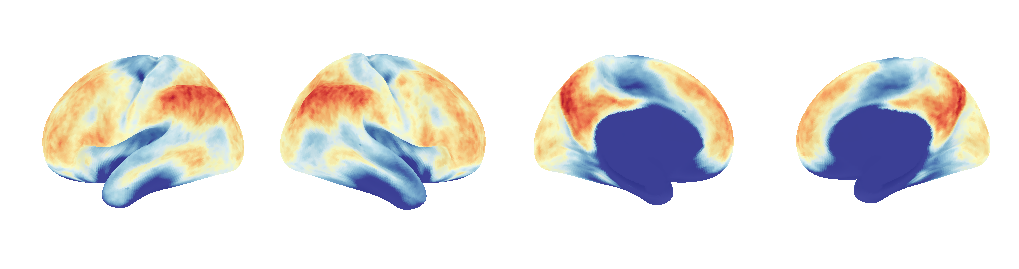

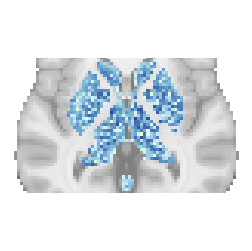

In [4]:
# !! make fig05-c: modify code block to plot all other panels !! #

estimator, estimates = "lls", "tstat_N"

# subset grayordinates into surface vertices and subcortex voxels
vmax = nb.get_vmax(hcp.cortex_data(maps["lls"][estimates]), hcp.cortex_data(maps["nls"][estimates]))
print(f"cbar = 0-{vmax}")

# plot surface
fig, axs = plt.subplots(ncols=4, figsize=(10, 3), subplot_kw=dict(projection="3d"))
fig.tight_layout(pad=0)

kwargs = dict(bg_on_data=True, darkness=1, alpha=0.25, cmap="RdYlBu_r", colorbar=False, vmin=0, vmax=vmax)
kwargs_l = {
    **kwargs,
    "surf_mesh": hcp.mesh.inflated_left,
    "surf_map": hcp.left_cortex_data(maps[estimator][estimates]),
    "bg_map": hcp.mesh.sulc_left,
    "hemi": "left",
}
kwargs_r = {
    **kwargs,
    "surf_mesh": hcp.mesh.inflated_right,
    "surf_map": hcp.right_cortex_data(maps[estimator][estimates]),
    "bg_map": hcp.mesh.sulc_right,
    "hemi": "right",
}

_ = plotting.plot_surf(view="lateral", axes=axs[0], **kwargs_l)
_ = plotting.plot_surf(view="lateral", axes=axs[1], **kwargs_r)
_ = plotting.plot_surf(view="medial", axes=axs[2], **kwargs_l)
_ = plotting.plot_surf(view="medial", axes=axs[3], **kwargs_r)

# plot volume
fig, ax = plt.subplots(figsize=(3, 3))
cifti_ax = nib.cifti2.load("data/nregions-300_cifti.dlabel.nii").header.get_axis(1)
plot = plotting.plot_stat_map(
    nb.cifti_to_volume(maps[estimator][estimates], cifti_ax),
    axes=ax,
    display_mode="z",
    cut_coords=[0],
    black_bg=False,
    annotate=False,
    colorbar=False,
    cmap="RdYlBu_r",
    vmax=vmax,
    symmetric_cbar=False,
)

plot.axes[0].ax.set_xlim(-75, 75)
plot.axes[0].ax.set_ylim(-60, 27)

['Frontoparietal', 'Default', 'Dorsal Attention', 'Visual', 'Ventral Attention', 'Somatomotor', 'Limbic']


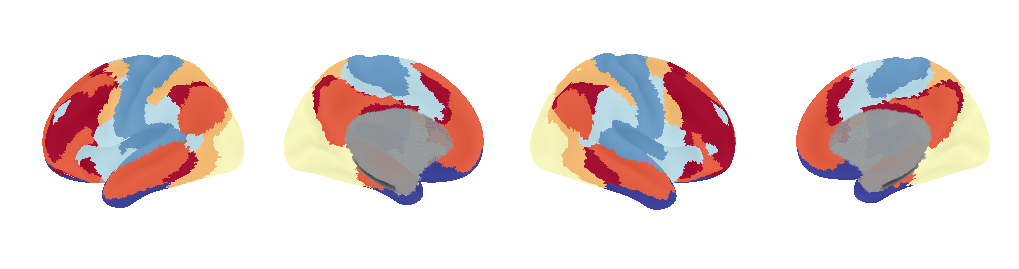

In [5]:
parc = hcp.yeo7
maps_parc = hcp.parcellate(maps[estimator][estimates].reshape(1, -1), parc, method=np.mean).squeeze()

print([parc.labels[i + 1] for i in maps_parc.argsort()[::-1]])

rank_bins = (maps_parc.argsort().argsort() * maps_parc.size) // maps_parc.size + 1
maps_unparc = hcp.unparcellate(rank_bins, parc)

colors = np.vstack(([1, 1, 1, 1], plt.cm.RdYlBu_r(np.linspace(0, 1, maps_parc.size))))
cmap = ListedColormap(colors)


# plot parcellation
fig, axs = plt.subplots(ncols=4, figsize=(10, 3), subplot_kw=dict(projection="3d"))
fig.tight_layout(pad=0)

kwargs = dict(bg_on_data=True, darkness=1, alpha=0.25, cmap=cmap)
kwargs_l = {
    **kwargs,
    "surf_mesh": hcp.mesh.inflated_left,
    "roi_map": hcp.left_cortex_data(maps_unparc),
    "bg_map": hcp.mesh.sulc_left,
    "hemi": "left",
}
kwargs_r = {
    **kwargs,
    "surf_mesh": hcp.mesh.inflated_right,
    "roi_map": hcp.right_cortex_data(maps_unparc),
    "bg_map": hcp.mesh.sulc_right,
    "hemi": "right",
}

_ = plotting.plot_surf_roi(view="lateral", axes=axs[0], **kwargs_l)
_ = plotting.plot_surf_roi(view="medial", axes=axs[1], **kwargs_l)
_ = plotting.plot_surf_roi(view="lateral", axes=axs[2], **kwargs_r)
_ = plotting.plot_surf_roi(view="medial", axes=axs[3], **kwargs_r)